# CS 109A/AC 209A/STAT 121A Data Science: Homework 2 (Solutions)
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, September 21st, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW2.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
import random
import sklearn as sk
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.cross_validation import train_test_split as sk_split
from sklearn.linear_model import LinearRegression as Lin_Reg
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

---

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Last, First]

### Part (b): Course Number

[CS 109a or STATS 121a or AC 209a]

### Part (c): Who did you work with?

[First and Land names of students with whom you have collaborated]

---

## Problem 1: Inside the Models in Scikit-learn

In this problem, we will be implementing K-Nearest Neighbour and simple linear regression for predicting a quantitative variable. We will compare the performance of our implementation with those of Scikit-learn (``sklearn``).

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the dependent variable Y, and the second column containing the independent variable X. 

### Part (a): Implement the models by hand
In this part you **may not** use ``sklearn`` for any task.

In the following, you may use ``numpy`` arrays instead of ``pandas`` dataframes.

- Implement a funtion ``split``, which satifies:
    - input: an ``nx2`` dataframe ``data``, a float ``m``
    - return: an ``nx2`` dataframe ``train`` and an ``nx2`` dataframe ``test``, consisting of ``m`` percent and ``100 - m`` percent of the data, respectively.


- Implement K-Nearest Neighbour for predicting a quantitative variable. That is, write a function, ``knn_predict``, that satisfies:
    - input: an integer ``k``, an ``n x 2`` dataframe training set ``train``, an ``n x 1`` dataframe testing set ``test``
    - return: an ``nx2`` dataframe, whose first column is that of ``test`` and whose second column is the predicted values.



- Implement linear regression for predicting a quantitative variable. That is, write a function ``linear_reg_fit`` that satisfies:
    - input: an ``nx2`` dataframe training set ``train``
    - return: the coefficients of the linear regression model - a float ``slope`` and a float ``intercept``.
    
    
- Write a function ``linear_reg_predict`` that satisfies:
    - input: an ``nx1`` dataframe testing set ``test``, as well as the coefficients of the linear regression model
    - return: an ``nx2`` dataframe, whose first column is that of ``test`` and whose second column is the predicted values.
    
    
- Implement a function ``score`` that satisfies:
    - input: an ``nx2`` dataframe ``predicted``, an ``nx2`` dataframe ``actual`` 
    - return: R^2 coefficient of the fit of the predicted values.

**Solution:**

After some thought, we realize that we had already implemented nearly all these functions in Problems 2 and 3 from Homework #1. We just need to tweek them slightly. For example, instead of finding the one nearest neighbour, we need to find the nearest $k$ number of them. Instead of evaluating quality by number/percent correctly classified, we compute the R^2 coefficient.

In [6]:
#--------  split
#input: data (nxm dataframe of all data)
#output: train (jxm dataframe of training data), test ((n-j)xm dataframe of testing data)

def split(data):
    
    #find the number of records dataframe
    length = data.shape[0]
    #build a list of integer indices for records in dataframe
    indices = range(length)
    #randomly shuffle the indices
    np.random.shuffle(indices)
    
    #take 70% of the shuffled list of indices for training
    train_indices = indices[0:int(length * .7)]
    #take the remainder the shuffled list of indices for testing
    test_indices = indices[int(length * .7):]
    
    #get the records for the training indices
    train = data.iloc[train_indices]
    #get the records for the testing indices
    test = data.iloc[test_indices]
    
    return train, test


#--------  evaluate
#input: predicted (nx2 dataframe of x vals and predicted y vals), 
#       true (nx2 dataframe of x vals and true y vals)
#output: r (R^2 coefficient float)

def evaluate(predicted, true):
    
    #compute the squared error
    comparison = (predicted['y'] - true['y'])**2
    
    #compute the R^2 codefficient
    error_var = comparison.sum()
    sample_var = ((true['y'] - true['y'].mean())**2).sum()
    
    r = (1 - error_var / sample_var)
    
    return r


#--------  knn_predict
#input: train (jx2 dataframe), test((n-j)x2 dataframe)
#output: predict ((n-j)x2 dataframe of x vals and predicted y vals)

def knn_predict(train, test, k):
    
    #start a list to store predicted y_values
    predict_y = []
    
    for index, test_row in test.iterrows():
        #for each test point, store the distance between all training points and test point in an series
        distances = (train['x'] - test_row['x'])**2 
        
        #sort the distances to training points (in ascending order) and take the first k points
        nearest_k = distances.sort_values().iloc[:k]
        
        #take the mean of the y-values corresponding to the nearest k points
        k_mean = train.loc[nearest_k.index, 'y'].mean()
        
        #add the mean to our predicted y-value list
        predict_y.append(k_mean)
    
    #create a dataframe with the x-values from test and predicted y-values
    predict = test.copy()    
    predict.loc[:, 'y'] = pd.Series(predict_y, index=test.index)
    
    return predict

#--------  lin_fit
#input: train (jx2 dataframe)
#output: m, b (floats)

def lin_fit(train):
    
    n = train.shape[0]
    
    numerator = (n * (train['x'] * train['y']).sum() 
           - (train['x'].sum() * train['y'].sum()))
    
    denominator = n * (train['x']**2).sum() - (train['x'].sum())**2

    m = numerator / denominator
    
    b = train['y'].mean() - m * train['x'].mean()
    
    return m, b


#--------  lin_predict
#input: test((n-j)x2 dataframe), m (float), b (float)
#output: predict ((n-j)x2 dataframe)

def lin_predict(test, m, b):
    
    #create a dataframe with the x-values from test and predicted y-values
    predict = test.copy()    
    predict.loc[:, 'y'] = predict['x'].apply(lambda x: m * x + b)
    
    return predict

### Part (b): Compare with ``sklearn``

- Load the contents of ``dataset_1_full.txt`` into a ``pandas`` dataframe, or ``numpy`` array. 


- Use your functions from Part (a) to split the data into training and testing sets (70-30). Evaluate how KNN and linear regression each perform on this dataset.


- Use ``sklearn`` to split the data into training and testing sets (70-30). Use ``sklearn`` to evaluate how KNN and linear regression each perform on this dataset.


- Use Python's ``time`` library to measure how well your implementations compare with that of ``sklearn``. What can you do (algorithmically or codewise) to make your implementation faster or more efficient?

**Solution:**

In [3]:
df = pd.read_csv('./dataset/dataset_1_full.txt')

#set number of neighbours
k = 3

Timing KNN implementations:

In [4]:
#performance of our own implementation

#split data
start = time.time()
train, test = split(df)
split_time = time.time() - start

#predict
start = time.time()
predicted = knn_predict(train, test, k)
predict_time = time.time() - start

#evaluate
start = time.time()
r = evaluate(predicted, test)
eval_time = time.time() - start

print 'R^2 value of KNN fit, for k=', k, ': ', r
print 'time for split:', split_time
print 'time for predict + eval:', eval_time + predict_time

R^2 value of KNN fit, for k= 3 :  0.316128582174
time for split: 0.0016348361969
time for predict + eval: 0.148900270462


In [5]:
#performance of sklearn implementation

#preparing data in array form
x = df['x'].values.reshape((df.shape[0], 1))
y = df['y'].values

#split data
start = time.time()
x_train, x_test, y_train, y_test = sk_split(x, y, test_size=0.30)
split_time = time.time() - start

#fit model, predict and evaluate
start = time.time()
neighbours = KNN(n_neighbors=k)
neighbours.fit(x_train, y_train)
r = neighbours.score(x_test, y_test)
eval_time = time.time() - start

print 'R^2 value of KNN fit, for k=', k, ': ', r
print 'time for split:', split_time
print 'time for predict + eval:', eval_time

R^2 value of KNN fit, for k= 3 :  0.157998203423
time for split: 0.000464916229248
time for predict + eval: 0.00197982788086


It looks like our implementation of data splitting is ~10 times as slow as that of ``sklearn`` and our knn-model implementation is ~100 times slower. In our ``knn_predict`` function, for each test data, we are iterating over the rows of the training dataframe to compute Euclidean distances. If there are 30 test data points and 70 train data points this will take 30*70 comparisions to complete. Besides looking for clever tricks to reduce the number of comparisons. We can ask if iterating over a ``pandas`` dataframe is efficient. For example, we can extract the values of the dataframe as a ``numpy`` array and iterate over the rows of this array. Would this make a difference (I highly encourage you to try it)? In fact, for those of you familiar with matrices and matrix operations, you might ask whether or not we need to iterate through the rows in the dataframe or array at all. We'll explore this question in the next homework.

In [6]:
#performance of our own implementation

#predict
start = time.time()
m, b = lin_fit(train)
fit_time = time.time() - start

start = time.time()
#predict
predicted = lin_predict(test, m, b)
predict_time = time.time() - start

#evaluate
r = evaluate(predicted, test)

print 'R^2 value of linear regression fit: ', r
print 'time for fitting:', fit_time
print 'time for predict:', predict_time

R^2 value of linear regression fit:  0.503713458429
time for fitting: 0.000804901123047
time for predict: 0.00155687332153


In [7]:
#performance of sklearn implementation

#preparing data as arrays
x_train = train['x'].values.reshape((train.shape[0], 1))
y_train = train['y'].values
x_test = test['x'].values.reshape((test.shape[0], 1))
y_test = test['y'].values

#fit linear model
start = time.time()
regression = Lin_Reg()
regression.fit(x_train, y_train)
fit_time = time.time() - start
    
#predict y-values
start = time.time()
predicted_y = regression.predict(x_test)
predict_time = time.time() - start

#score predictions
r = regression.score(x_test, y_test)


print 'R^2 value of linear regression fit: ', r
print 'time for fitting:', fit_time
print 'time for predict:', predict_time

R^2 value of linear regression fit:  0.503713458429
time for fitting: 0.000921964645386
time for predict: 0.0524458885193


Our implementation for linear regression is slower than that of sklearn but still comparable. This is b/c our implementation essentially performs arithmetic on ``pandas`` series using built-in functions and operators (these have already been optimized).

## Problem 2: Handling Missing Data

In this problem, we will be handling the problem of datasets with missing values. Clearly, we cannot simply remove entire rows or columns that contain missing values. In this problem, we explore two different ways to fill in missing values.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the independent variable X, and the second column containing the dependent variable Y

The files ``dataset_1_missing.txt`` to ``dataset_6_missing.txt`` contains rows that are missing their y-values, where as ``dataset_1_full.txt`` to ``dataset_6_full.txt`` contain datasets with all y-values correctly filled in.

In this problem, you **may not** use ``sklearn`` or build-in ``pandas`` functions to **directly fill in missing values**. Usage of these libraries/pakcages for related tasks is fine.

### Part (a): Model Based Data Imputation

- Describe in detail how predictive models for data (like KNN and simple linear regression) can be used to fill in missing values in a data set.


- Implement your scheme. That is, write code (preferably a function ``fill`` or two functions ``fill_knn``, ``fill_lin_reg``), which takes an ``n x 2`` dataframe or array with values missing in the 2nd column and fills in these values using KNN and linear regression. 


- You need to, also, write code to evaluate the quality of the values you've filled in.

**Solution:**

Function definitions:

In [2]:
#--------  fill_knn
#input: missing_df (nx2 dataframe, some rows have missing y vals), 
#       full_df (nx2 dataframe, all rows have correct y vals), 
#       no_y_ind (indices of rows missing_df in with missing y values), 
#       with_y_ind (indices of rows missing_df in with out missing y values), 
#       k (integer)
#output: predicted_df (dataframe), r (float)

def fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k):
    #spliting data into train/test and preparing data in array form
    
    #training set
    x_train = missing_df.loc[with_y_ind, 'x'].values
    x_train = x_train.reshape((len(with_y_ind), 1)) #make this array 2D (row, column)
    y_train = missing_df.loc[with_y_ind, 'y'].values
    
    #training set
    x_test = missing_df.loc[no_y_ind, 'x'].values
    x_test = x_test.reshape((len(no_y_ind), 1)) #make this array 2D (row, column)
    y_test = full_df.loc[no_y_ind, 'y'].values
    
    #fit knn model
    neighbours = KNN(n_neighbors=k)
    neighbours.fit(x_train, y_train)
    
    #predict y-values
    predicted_y = neighbours.predict(x_test)
    
    #score predictions
    r = neighbours.score(x_test, y_test)
    
    #fill in missing y-values
    predicted_df = missing_df.copy()
    predicted_df.loc[no_y_ind, 'y'] = pd.Series(predicted_y, index=no_y_ind)
    
    return predicted_df, r

#--------  fill_lin_reg
#input: missing_df (nx2 dataframe, some rows have missing y vals), 
#       full_df (nx2 dataframe, all rows have correct y vals), 
#       no_y_ind (indices of rows missing_df in with missing y values), 
#       with_y_ind (indices of rows missing_df in with out missing y values), 
#       k (integer)
#output: predicted_df (dataframe), r (float)


def fill_lin_reg(missing_df, full_df, no_y_ind, with_y_ind):
    #spliting data into train/test and preparing data in array form
    
    #training set
    x_train = missing_df.loc[with_y_ind, 'x'].values
    x_train = x_train.reshape((len(with_y_ind), 1)) #make this array 2D (row, column)
    y_train = missing_df.loc[with_y_ind, 'y'].values
    
    #training set
    x_test = missing_df.loc[no_y_ind, 'x'].values
    x_test = x_test.reshape((len(no_y_ind), 1)) #make this array 2D (row, column)
    y_test = full_df.loc[no_y_ind, 'y'].values
    
    #fit linear model
    regression = Lin_Reg()
    regression.fit(x_train, y_train)
    
    #predict y-values
    predicted_y = regression.predict(x_test)
    
    #score predictions
    r = regression.score(x_test, y_test)
    
    #fill in missing y-values
    predicted_df = missing_df.copy()
    predicted_df.loc[no_y_ind, 'y'] = pd.Series(predicted_y, index=no_y_ind)
    
    return predicted_df, r
    

### Part (b): Which Model is Better?

- For datasets ``dataset_1_missing.txt`` to ``dataset_6_missing.txt``, compare the result of filling in the missing values using KNN and linear regression, using both the R^2 coefficient as well as data visualization. 


- Use your analysis to form conjectures regarding the conditions under which KNN performs better than linear regression, under which linear regression performs better than KNN and under which both perform equally (well or poorly). Explain in detail exactly what might cause each model to fail or perform well. 



- Using ``dataset_1_missing.txt``, explain the impact of the choice of $k$ on the performance of KNN. 


Use numerical analysis and data visualization to support every part of your argument.

**Solution:**

Evaluate predicted values using linear regression vs KNN.

In [9]:
missing_df = pd.read_csv('./dataset/dataset_1_missing.txt')
full_df = pd.read_csv('./dataset/dataset_1_full.txt')

no_y_ind = missing_df[missing_df['y'].isnull()].index
with_y_ind = missing_df[missing_df['y'].notnull()].index

#number of neighbours
k=3

predicted_knn, r_knn = fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k)
print 'R^2 value of KNN fit, for k=', k, ': ', r_knn

predicted_lin, r_lin = fill_lin_reg(missing_df, full_df, no_y_ind, with_y_ind)
print 'R^2 value of linear regression fit:', r_lin

R^2 value of KNN fit, for k= 3 :  0.258310285163
R^2 value of linear regression fit: 0.439984606107


Clearly with $k=3$, KNN produces inferior predictions. Let's test the effect of $k$ on the quality of filled in values:

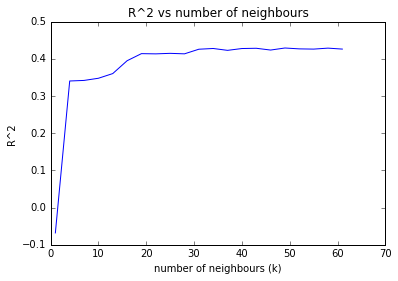

In [10]:
r_val = []
for k in range(1, 64, 3):
    _, r_knn = fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k)
    r_val.append(r_knn)
    
plt.plot(range(1, 64, 3), r_val)
plt.title('R^2 vs number of neighbours')
plt.xlabel('number of neighbours (k)')
plt.ylabel('R^2')
plt.show()

Clearly, as k increases our prediction for the missing values get better. But the effect of increasing $k$ on R^2 plateaus after 0.4. What happens when $k$ is close to the size of the training set? That is, for every testing point, we use the entire training set to determine our prediction?

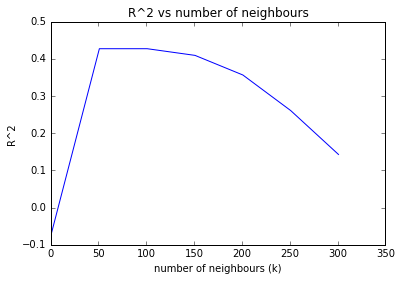

In [11]:
r_val = []
for k in range(1, 351, 50):
    _, r_knn = fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k)
    r_val.append(r_knn)
    
plt.plot(range(1, 351, 50), r_val)
plt.title('R^2 vs number of neighbours')
plt.xlabel('number of neighbours (k)')
plt.ylabel('R^2')
plt.show()

As $k$ approaches the size of the entire training set, the we end up always predicting the y-value to be the mean of the training y-values and hence quality of prediction goes down (can you intuitively see why? **Hint:** look at the scatter plot for dataset_1).

In [12]:
#--------  plot_missing
#input: ax1 (axes), ax2 (axes), 
#       dataset_name (string), 
#       predicted_knn (nx2 dataframe with predicted vals), r_knn (float),
#       predicted_lin (nx2 dataframe with predicted vals), r_lin (float), 
#       k (integer),
#       no_y_ind (indices of rows with missing y-values),
#       with_y_ind (indices of rows with no missing y-values)
#output: ax1 (axes), ax2 (axes)

def plot_missing(ax1, ax2, 
                 dataset_name, 
                 predicted_knn, r_knn, 
                 predicted_lin, r_lin, 
                 k, 
                 no_y_ind, with_y_ind):
    
    #plot scatter for KNN predictions
    
    #scatter of points with no missing y-val
    ax1.scatter(predicted_knn.loc[with_y_ind]['x'].values, 
                predicted_knn.loc[with_y_ind]['y'].values, 
                color='blue', 
                alpha=0.5,
                label='Train: no missing y-val')
    
    #scatter of points with missing y-val
    ax1.scatter(predicted_knn.loc[no_y_ind]['x'].values, 
                predicted_knn.loc[no_y_ind]['y'].values, 
                color='red',
                alpha=0.5,
                label='Test: predicted y-val\nR^2=' + str(round(r_knn, 2)))
    
    ax1.legend(loc='best')

    ax1.set_title(dataset_name + ', KNN, k=' + str(k) )

    #plot scatter for KNN predictions
    
    #scatter of points with no missing y-val
    ax2.scatter(predicted_lin.loc[with_y_ind]['x'].values, 
                predicted_lin.loc[with_y_ind]['y'].values,
                color='blue',
                alpha=0.5,
                label='Train: no missing y-val')

    #scatter of points with missing y-val
    ax2.scatter(predicted_lin.loc[no_y_ind]['x'].values, 
                predicted_lin.loc[no_y_ind]['y'].values, 
                color='green',
                alpha=0.5,
                label='Test: predicted y-val\nR^2=' + str(round(r_lin, 2)))
    
    ax2.legend(loc='best')

    ax2.set_title(dataset_name + ', Linear regression')
    
    return ax1, ax2

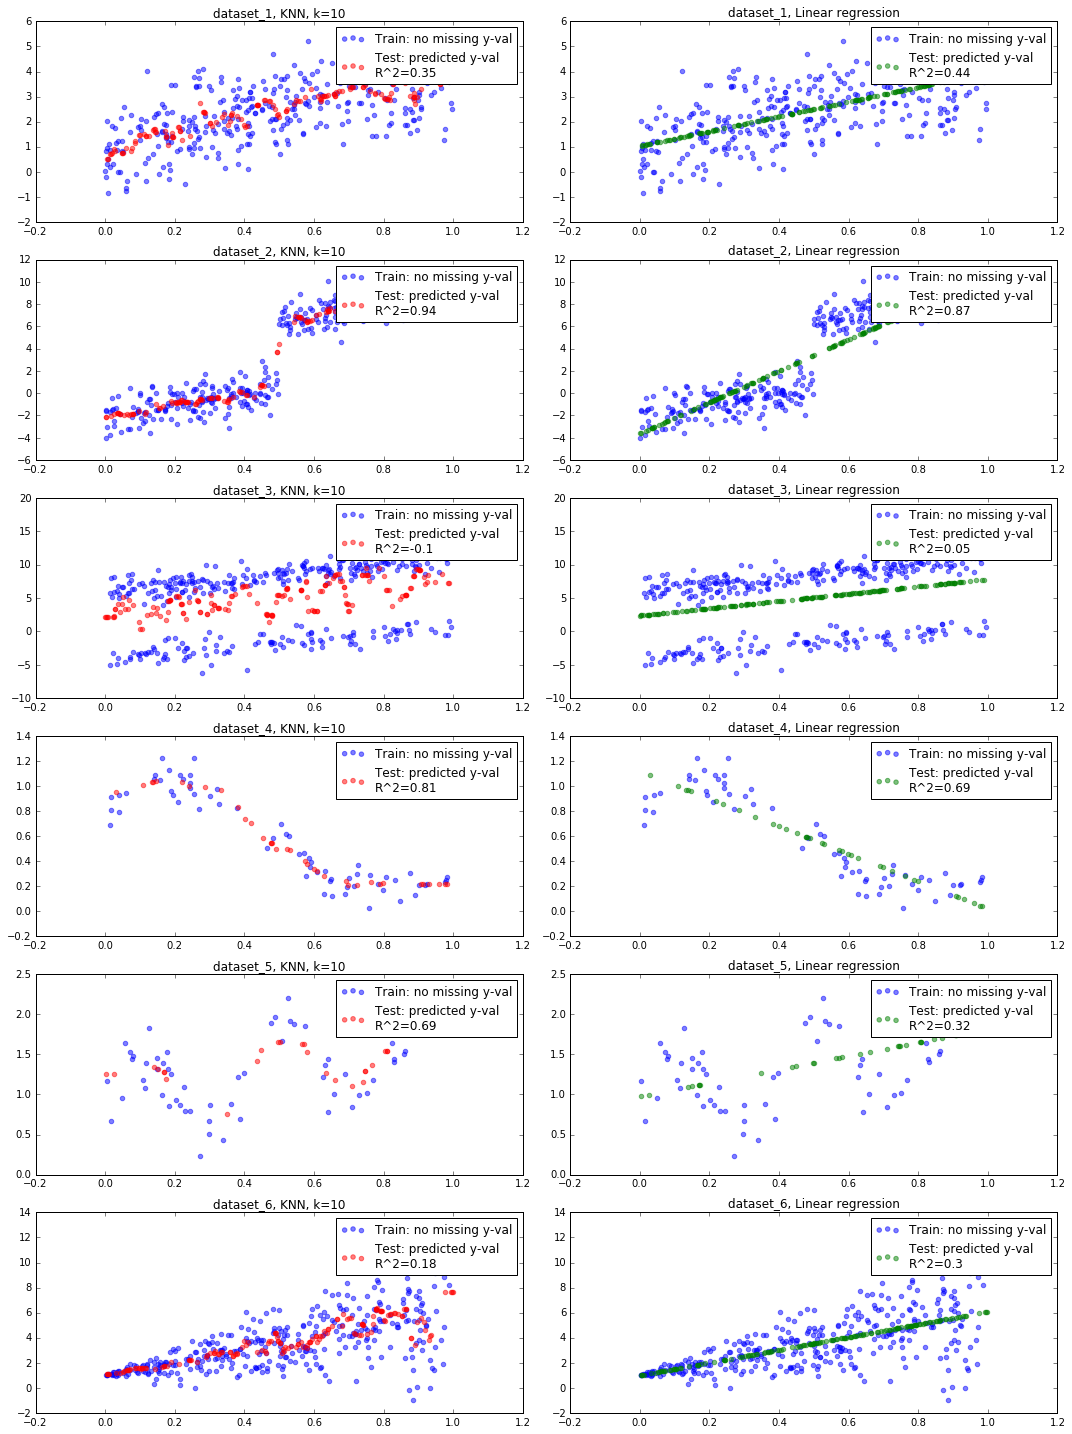

In [24]:
#number of neighbours
k=10

#plot predicted points
fig, axes = plt.subplots(6, 2, figsize=(15, 20))

for i in range(1, 7):
    missing_df = pd.read_csv('./dataset/dataset_' + str(i) + '_missing.txt')
    full_df = pd.read_csv('./dataset/dataset_' + str(i) + '_full.txt')

    no_y_ind = missing_df[missing_df['y'].isnull()].index
    with_y_ind = missing_df[missing_df['y'].notnull()].index

    predicted_knn, r_knn = fill_knn(missing_df, full_df, no_y_ind, with_y_ind, k)

    predicted_lin, r_lin = fill_lin_reg(missing_df, full_df, no_y_ind, with_y_ind)
    
    row_num = (i - 1) * 2

    fig.axes[row_num], fig.axes[row_num + 1] = plot_missing(fig.axes[row_num], 
                                                            fig.axes[row_num + 1],
                                                            'dataset_' + str(i),
                                                            predicted_knn, r_knn,
                                                            predicted_lin, r_lin,
                                                            k,
                                                            no_y_ind, 
                                                            with_y_ind)

plt.tight_layout()
plt.show()

**Outline:**

While linear regression clearly performs better than KNN in the first dataset, KNN performs better than linear regression in nearly every other dataset (with the exception of dataset #3, where both models perform poorly). From the scatter plots we see that the advantage of KNN is that it tends to perform better when the data is not linear and when the shape of the distribution is odd. On the other hand, when the data is "linear", whatever that means, linear regression performs better than KNN (even with a high choice of $k$). 

So when does the KNN model fail? Since KNN makes predictions based on nearest neighbours, if the nearest neighbours are very disimilar to a point (meaning the point is different from what you've seen), then the prediction won't be very good. As we can see from the scatter plots, when entire contiguous chunks of data are missing then KNN can do poorly. When the nearest neighbours show extreme variation (nearest neighbours all look different) KNN does poorly.

**Note:** before exploring the data, it is hard to say before hand that KNN will fail/has failed; and when it does it may be difficult to see why when the data is high dimensional (hard to visualize). In contrast, it is often much easier to diagnose when linear regression fails and we can diagnose the source of the failure much more rigorously (See Problem 3).

---

## Problem 3: Is the Best (Linear Model) Good Enough?

In this problem, we will specifically look at conditions under which linear regression excels or fails.

The datasets required for this problem is in the ``dataset`` directory. Each file in the ``dataset`` directory contains a one-dimensional data set, with the first column containing the dependent variable Y, and the second column containing the independent variable X. 

### Part (a): Introduction to Residual Plots

- Read ``dataset_1_full.txt``. Visualize the dataset and make some initial observations.


- For this data set, what can you say about the following linear fits: 

    1. slope = 0.4, intercept = 0.2
    2. slope = 0.4, intercept = 4
    3. linear regression model


- In each case, visualize the fit, compute the residuals, and make a residual plot of predicted values along with  residuals, as well as a residual histogram. What do these plots reveal? 


- Calculate the R^2 coefficient for all three fits. What do the erors reveal? How do they compare to the residual plots?

In [3]:
#plot predicted points

def plot_residual(ax1, ax2, ax3, data, line, line_label):
    ax1.scatter(data['x'].values, 
                data['y'].values, 
                color='blue',
                alpha=0.6,
                label='Data')

    ax1.plot(line['x'].values, 
             line['y'].values,
             color='black',
             linewidth=2.0,
             alpha=0.7,
             label=line_label)

    ax1.legend(loc='best')
    ax1.set_title('Data with linear model')

    ax2.scatter(line['x'].values,
                data['y'].values - line['y'].values, 
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(data['y'].values - line['y'].values, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    return ax1, ax2, ax3

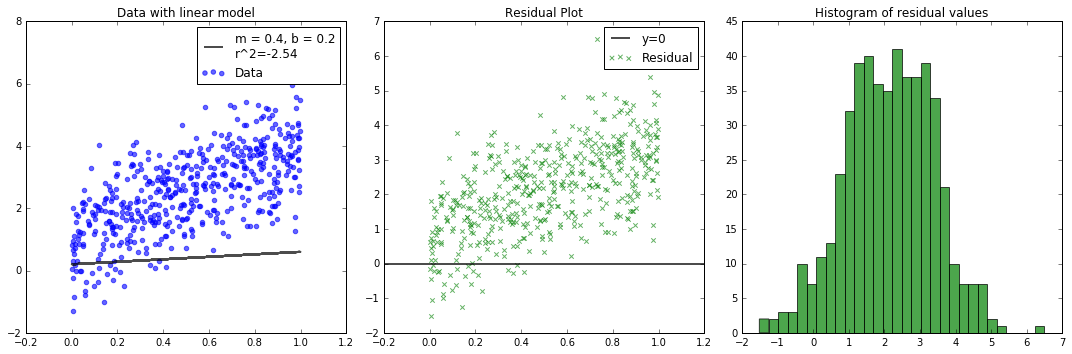

In [8]:
df = pd.read_csv('./dataset/dataset_1_full.txt')

### First Model

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

line = df.copy()
line['y'] = df['x'].apply(lambda x: 0.4 * x + 0.2)

r = evaluate(line, df)

ax1, ax2, ax3 = plot_residual(ax1, ax2, ax3, df, line, 'm = 0.4, b = 0.2\n' + 'r^2=' + str(round(r, 2)))

plt.tight_layout()
plt.show()

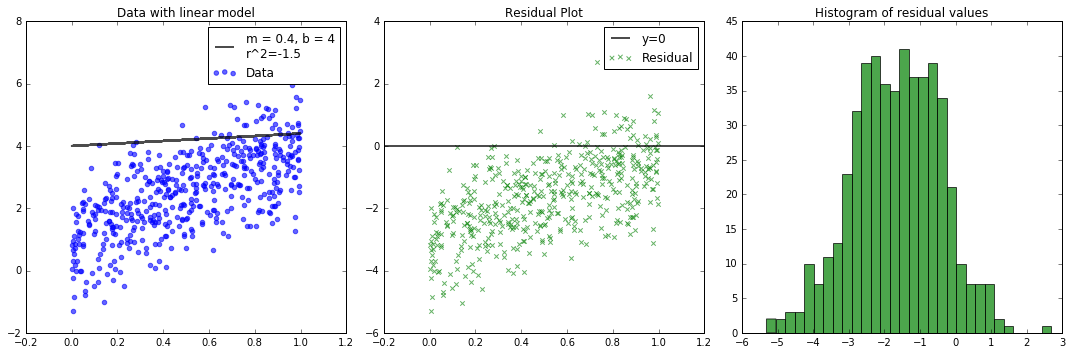

In [7]:
### Second Model

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

line = df.copy()
line['y'] = df['x'].apply(lambda x: 0.4 * x + 4)

r = evaluate(line, df)

ax1, ax2, ax3 = plot_residual(ax1, ax2, ax3, df, line, 'm = 0.4, b = 4\n' + 'r^2=' + str(round(r, 2)))

plt.tight_layout()
plt.show()

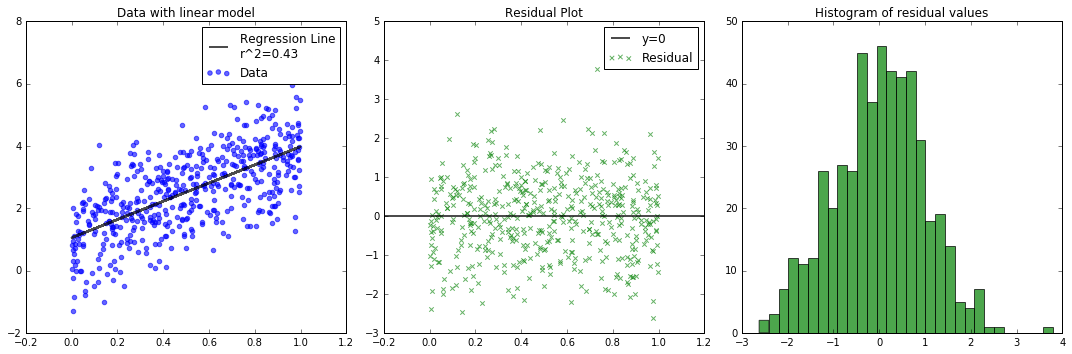

In [17]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

#preparing data in array form
x_data = df['x'].values.reshape((df.shape[0], 1))
y_data = df['y'].values
   
#fit linear model
regression = Lin_Reg()
regression.fit(x_data, y_data)
    
#predict y-values
predicted_y = regression.predict(x_data)

#score predictions
r = regression.score(x_data, y_data)

line = df.copy()
line['y'] = pd.Series(predicted_y, index=df.index)



ax1, ax2, ax3 = plot_residual(ax1, ax2, ax3, df, line, 'Regression Line\n' + 'r^2=' + str(round(r, 2)))

plt.tight_layout()
plt.show()

So far we haven't seen any negative R^2 values (with the exception of the KNN fit for  ``dataset_3`` in Problem 2). What do negative R^2 values mean? Recall that R^2 is defined as
$$
1 - \frac{\text{sum of squared errors}}{\text{sum of squared squared deviation in} y} = 1 - \frac{\sum_i (\hat{y}_i - y_i)^2}{\sum_i (y_i - \bar{y})^2}
$$

Since the observed responses, $y$'s, are known before hand and are fixed, R^2 is a function of SSE. That is, if SSE is large then R^2 will be small and if SSE is small then R^2 will tend towards 1.

Given a data set with maximum $y$-value, say $y_{max}$, and let's choose a linear model $\hat{y} = y_{huge}$, where $y_{huge}$ is much larger than $y_{max}$ (i.e. our line lies way above the scatter plot of the data points in the x, y-plane). If we make $y_{huge}$ larger and larger (i.e our line moves away from the data points), then it is clear that we can make the SSE arbitrarily large and thus R^2 arbitrarily negative!

So why don't we see negative R^2 values when we evaluate **linear regression models**? Recall that every linear regression models is guaranteed, by construction, to fit the data at least as well as the model $\hat{y} = \bar{y}$ (can you see why?). Thus, 
$$
\sum_i (\hat{y}_i - y_i)^2 \leq \sum_i (y_i - \bar{y})^2
$$
and so R^2 will always be greater or equal to zero.

The residual plots and histograms can help us check if a model over-estimates or under-estimates the data. For example, if most of the residual points are below zero, then the line is over-estimating (this can also be seen from the histogram with a single mode below zero). While the histogram tells us if the model under or overestimates in general, the residual plots tell us **where exactly** the model is over or under estimating the data. Using the residual plots and histogram, we can intuitive see why the regression line is the best fitting linear model for the data: from the residual plot we see that it neither over-estimates or under-estimates the data, and from the histogram we see that the error is most likely zero (the mode is at zero). 

### Part (b): What do Residual Plots Reveal?

- Read datasets ``dataset_2_full.txt`` through ``dataset_6_full.txt``. In each case, visualize the fit, compute the residuals, and make a residual plot of predicted values along with  residuals, as well as a residual histogram. What do these plots reveal about the fit of the model? 


- Calculate the R^2 coefficient each fit. What do the erors reveal? How do they compare to the residual plots?


- Based on your analysis, form conjectures regarding the precise relationship between the residual plots and the fit of the linear regression model. Conjecture on the precise conditions under which linear regression model is an appropriate model for a given dataset.

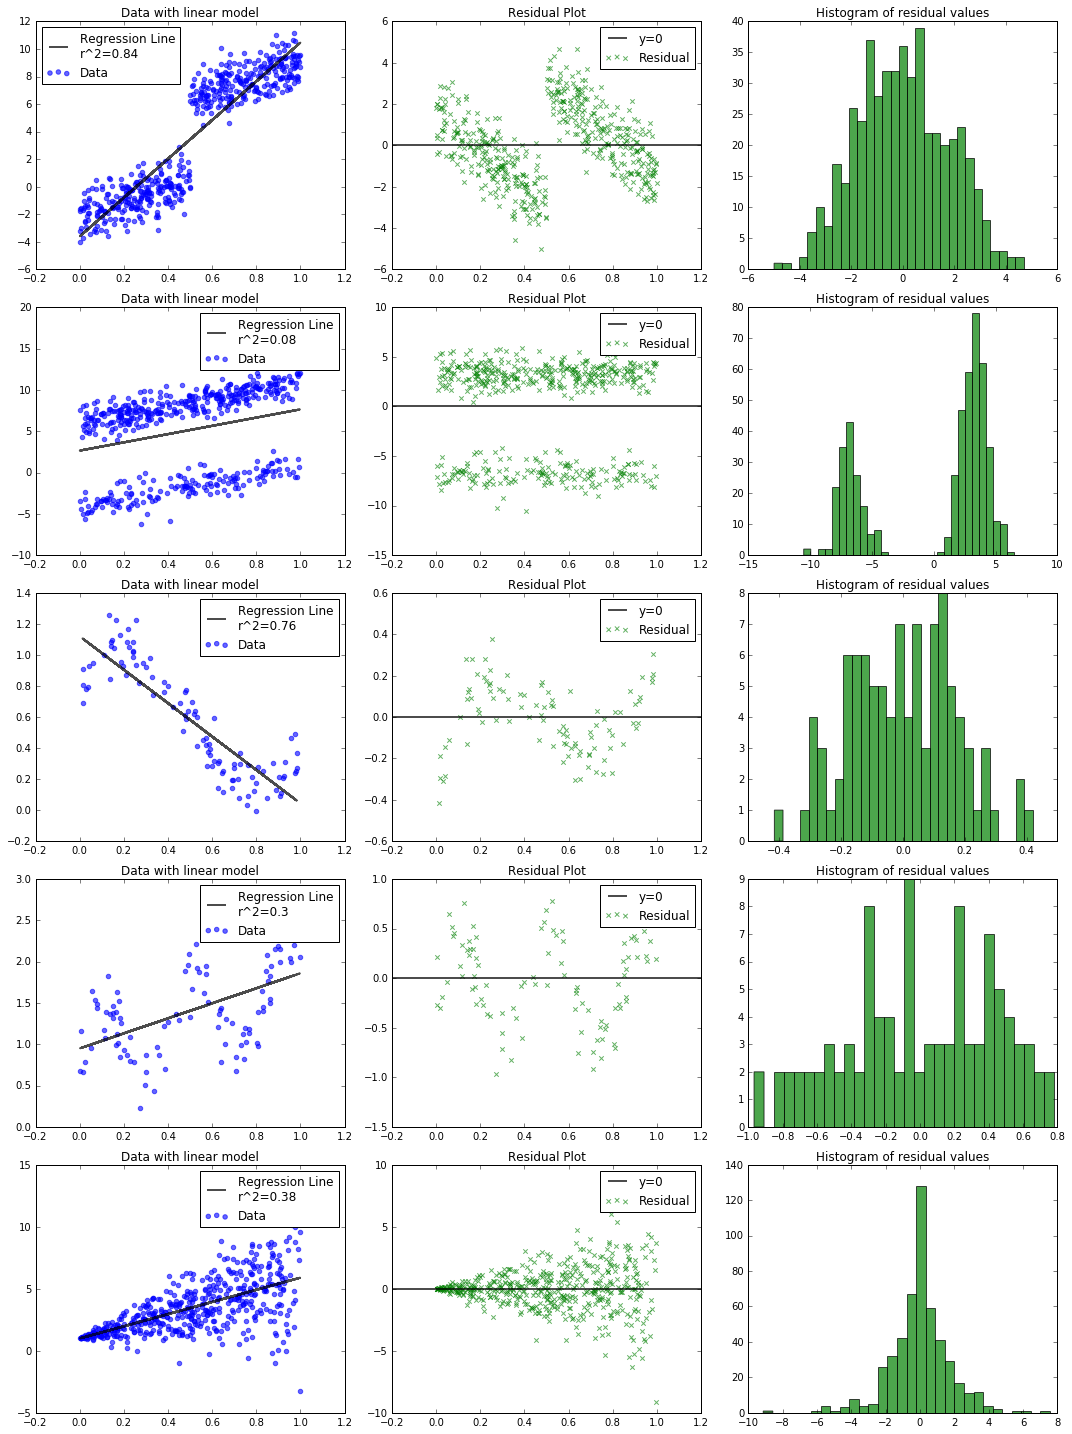

In [18]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

for i in range(2, 7):
    df = pd.read_csv('./dataset/dataset_' + str(i) + '_full.txt')

    #preparing data in array form
    x_data = df['x'].values.reshape((df.shape[0], 1))
    y_data = df['y'].values

    #fit linear model
    regression = Lin_Reg()
    regression.fit(x_data, y_data)

    #predict y-values
    predicted_y = regression.predict(x_data)
    
    #score predictions
    r = regression.score(x_data, y_data)

    line = df.copy()
    line['y'] = pd.Series(predicted_y, index=df.index)

    row = (i - 2) * 3

    fig.axes[row], fig.axes[row + 1], fig.axes[row + 2] = plot_residual(fig.axes[row], 
                                                                        fig.axes[row + 1], 
                                                                        fig.axes[row + 2], 
                                                                        df, 
                                                                        line, 
                                                                        'Regression Line\n' 
                                                                        + 'r^2=' 
                                                                        + str(round(r, 2)))


plt.tight_layout()
plt.show()

**Outline:**

In the above, we can see that the residual plots and histograms are good tools for determining whether or not a linear regression model is appropriate for our data. 

In cases where the R^2 coefficient is small, the residual plots and the histograms help explain why the linear regression model fails: b/c residuals are not concentrated at zero, or b/c the variance of residuals is not constant across all x-values (around some x-values the residuals vary little, around other they vary alot). 

In cases where the R^2 coefficient is larger, the residual plot nontheless show us whether or not the regression line captures the trend in the data! In this case, visualization often tell us different things than the value of R^2.

In general, we observe that a linear regression model may be appropriate if

1. around each $x$-value the residuals are symmetrically concentrated around zero (normally distributed)
2. the variance in residuals are constant across different $x$-values


---

## Challenge Problem: Combining Random Variables

This problem, we explore the distirbution of random variables that result from combining other random variables.

### Part (a): Adding Two Uniformly Distributed Variables

Consider the independent random variables $X\sim U(0, 1)$ and $Y\sim U(0, 1)$. Let $Z$ be the random variable $Z = X + Y$. 

What is the distribution of $Z$ (give the pdf for Z)? You should fully explain and support your conlusion. 

**Hint:** your solution can be a combination of experimentation, empirical evidence and/or algebra

**Possible Solution:**

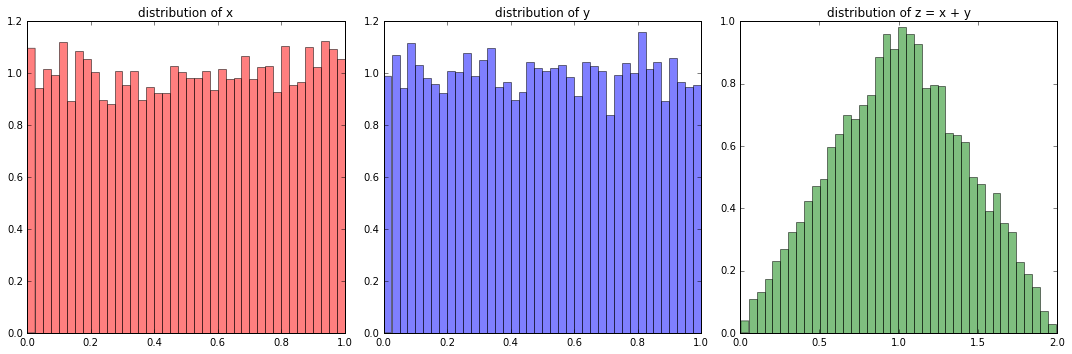

In [43]:
x = np.random.uniform(0, 1, size=10000)
y = np.random.uniform(0, 1, size=10000)

z = x + y

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(x, color='red', bins=40, alpha=0.5, normed=1)
ax1.set_title('distribution of x')

ax2.hist(y, color='blue', bins=40, alpha=0.5, normed=1)
ax2.set_title('distribution of y')

ax3.hist(z, color='green', bins=40, alpha=0.5, normed=1)
ax3.set_title('distribution of z = x + y')

plt.tight_layout()
plt.show()

It looks like that the sum of two random variable with standard uniform distributions is not uniformly distributed. It's is a piecewise linear function distribution. To *prove* that the distribution of $Z$ is piecewise linear will take a bit more mathematics (although there are a number of arguments that by-passes any mention of integrals).

For the sake of simplicity, let's assume that $X$ and $Y$ are discrete RVs each taking on values in $\{1, 2, 3, 4, 5\}$. What is the probability that $Z = 2$? Since $Z = 2$ exactly when $Y=1$ and $X=1$, we must have that
$$
P(Z = 2) = P(Y = 1) P(X = 1)
$$
What is the probability that $Z = 4$? Since many different values for $X$ and $Y$ can yield $Z = 4$, we need to take into account all of these combinations:
$$\begin{aligned}
P(Z = 4) &= P(Y = 1) P(X = 3) + P(Y = 3) P(X = 1) + P(Y = 2) P(X = 2) \\
&= \sum_{i = 1}^3 P(Y = 4 - i)P(X = i)
\end{aligned}
$$
Extending this line of reasoning to the infinite case (recall that infinite sums generally correspond to integrals), for when $X$, $Y$ and $Z$ are continuous RVs of one real variable, we obtain:
$$
f_Z(z) = \int_{-\infty}^{\infty} f_Y(z - x) f_X(x) dx
$$
where $f_Z$, $f_Y$ and $f_X$ are the pdf's of $Z$, $Y$ and $X$ correspondingly. The function constructed by
$$
H(z) = \int_{-\infty}^{\infty} f(z - x) g(x) dx
$$
is called the **convolution** of functions $f$ and $g$. Plugging in the standard uniform distribution pdf for $f_X$ and $f_Y$, we obtain a closed expression for the pdf of $Z$.

On the other hand, if we simply accept that the histograms as evidence that the pdf of $Z$ forms a isoceles triangle, we can also find a closed expression for the pdf of $Z$.

Note that, according to the histogram and common sense, $Z$ takes value in $[0, 2]$. Now, we just need to find the hight of the triangle (at $Z=1$) and we will be able to produce the equations of the two linear pieces. 

Recall that the pdf for any random variable satisfies that the area lying under the graph of the pdf is 1. Let $h$, $b$ be the height and base of the isoceles triagle formed by the pdf of $Z$ and the horizontal axis, then
$$
1 = \frac{1}{2}*b*h = \frac{1}{2}*2*h 
$$
Thus, we find that $h=1$, and the pdf of $Z$ is
$$
f_Z(z) = \begin{cases}
z & z \in [0, 1]\\
-z + 20 & z\in [1, 2]\\
0 & \text{otherwise}
\end{cases}
$$

### Part (b): Adding Multiple Uniformly Distributed Variables

Consider three independent random variables $X_1, X_2, X_3 \sim U(0, 1)$. Let $Z$ be the random variable $Z = X_1 + X_2 + X_3$. 

What is the distribution of $Z$? What if you add 10 or 12 independent (standard) uniformly distributed variables? Conjecture on the distribution of 
$$
Z = \lim_{n\to \infty} \sum_{i=1}^n X_i
$$
where $\left\{X_i \right\}$ are independent (standard) uniformly distributed variables.

**Hint:** your solution can be a combination of experimentation, empirical evidence and/or algebra

**Solution:**

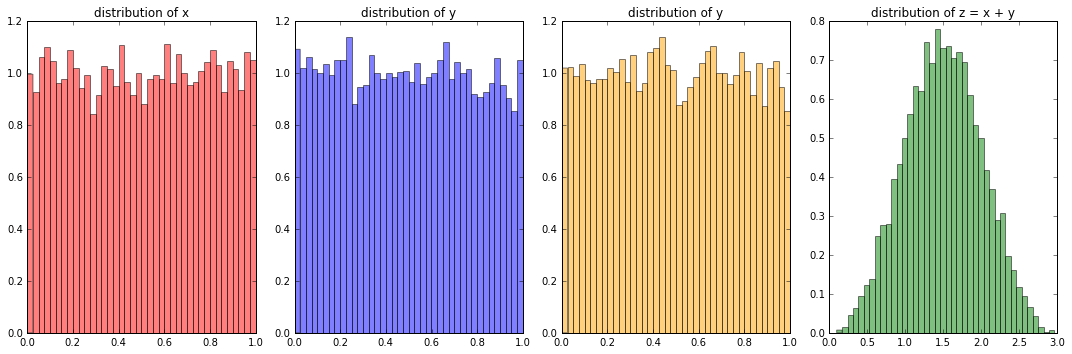

In [37]:
x_1 = np.random.uniform(0, 1, size=10000)
x_2 = np.random.uniform(0, 1, size=10000)
x_3 = np.random.uniform(0, 1, size=10000)

z = x_1 + x_2 + x_3

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(15, 5))

ax1.hist(x_1, color='red', bins=40, alpha=0.5, normed=1)
ax1.set_title('distribution of x')

ax2.hist(x_2, color='blue', bins=40, alpha=0.5, normed=1)
ax2.set_title('distribution of y')

ax3.hist(x_3, color='orange', bins=40, alpha=0.5, normed=1)
ax3.set_title('distribution of y')

ax4.hist(z, color='green', bins=40, alpha=0.5, normed=1)
ax4.set_title('distribution of z = x + y')

plt.tight_layout()
plt.show()

The pdf of the sum of three uniformly distributed RVs look less like a triangle, more curvy. Now let's try to add up more of these uniformly distributed RVs.

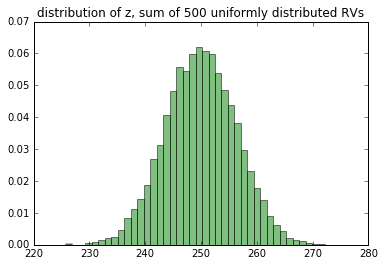

In [42]:
n = 500

n_vars = np.array([np.random.uniform(0, 1, size=10000) for i in range(n)])

z = n_vars.sum(axis=0)

plt.hist(z, color='green', bins=40, alpha=0.5, normed=1)
plt.title('distribution of z, sum of ' + str(n) + ' uniformly distributed RVs')

plt.show()

**Conjecture:** the sum of $n$ number of uniformly distributed RVs start to look more and more like normally distributed RV! This illustrates one of the fundamental theorems of probability, the Central Limit Theorem, which states that the sum of large numbers of identically distributed RVs will be approximatedly normal (regardless of the distribution of the RVs)!

### Part (c): Combining Normally Distributed Variables

Consider the independent random variables $X\sim \mathcal{N}(0, 1)$ and $Y\sim \mathcal{N}(0, 1)$. Let $Z$ be the random variable $Z = X + Y$. 

What is the distribution of $Z$ (give the pdf for Z)? You should fully explain and support your conlusion. 

**Hint:** use properties of expected value and some experimentation.

**Solution:**

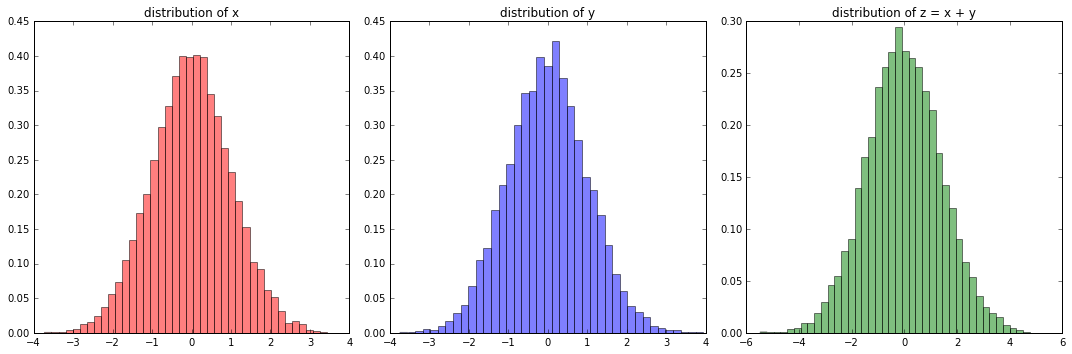

In [44]:
x = np.random.normal(0, 1, size=10000)
y = np.random.normal(0, 1, size=10000)

z = x + y

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(x, color='red', bins=40, alpha=0.5, normed=1)
ax1.set_title('distribution of x')

ax2.hist(y, color='blue', bins=40, alpha=0.5, normed=1)
ax2.set_title('distribution of y')

ax3.hist(z, color='green', bins=40, alpha=0.5, normed=1)
ax3.set_title('distribution of z = x + y')

plt.tight_layout()
plt.show()

It looks like that the sum of two variables with standard normal distributions is again normally distributed with mean zero but a different variance (or standard deviation). To *prove* that the distribution of $Z$ is normal will take a lot more mathematics. 

For example, recall from the above that the pdf of $Z$ is the convolution of the pdf's of $X$ and $Y$:
$$
\begin{aligned}
f_Z(z) = \int_{-\infty}^{\infty} f_Y(z - x) f_X(x) dx
\end{aligned}
$$
When we plug in the standard normal pdf for $f_Y$ and $f_X$, we obtain:
$$
\begin{aligned}
f_Z(z) &= \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\sigma_Y^2 \pi}} \mathrm{exp}\left \{ -\frac{1}{2} \left(\frac{(z-x)-\mu_Y}{\sigma_X} \right)^2 \right\} \frac{1}{\sqrt{2\sigma_Y^2 \pi}}\mathrm{exp}\left \{ -\frac{1}{2} \left(\frac{x-\mu_X}{\sigma_X} \right)^2 \right\} dx\\
&=\int_{-\infty}^{\infty} \frac{1}{2\pi\sigma_Y \sigma_X} \mathrm{exp}\left \{ -\frac{1}{2} \left( \left(\frac{(z-x)-\mu}{\sigma} \right)^2  + \left(\frac{x-\mu}{\sigma} \right)^2 \right)\right\} dx
\end{aligned}
$$
Now after [some algebra](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables) you will see that $f_Z$ is in fact the pdf of a normal distribution with mean $\mu_X + \mu_Y$ and variance $\sigma_X^2 + \sigma_Y^2$.

On the other hand, if we simply accept that the histograms as evidence that $Z \sim \mathcal{N}(\mu, \sigma^2)$, it then only remains to find $\mu$ and $\sigma^2$.

If you remember that **mean** or **expected value** distributes over sum, then we see that the mean of $X + Y$ must be the mean of $X$ plus the mean of $Y$. That is, the mean of $Z$ is $0$. In the following, we explain this property of the mean. 

Recall that the **mean** or **expected value** of a real-valued random variable, $X$, is defined as:
$$
\mathbb{E}[X] = \int_{-\infty}^{\infty} x f_X(x)dx
$$
where $f_X$ is the pdf of $X$. This integral is just the infinite version of the familiar mean or expected value of a discrete random variable, $X$, that has only $N$ number of possible values
$$
\mathbb{E}[X] = \sum_{i=0}^N x_i P(X = x_i)
$$
where $P(X = x_i)$ is the probability that the RV $X$ takes on the value $x_i$.

Now, suppose $X$ and $Y$ are RV's that can only take on a finite number of possible values and let $Z = X + Y$, then the possible values of $Z$ is finite. We can now compute
$$
\mathbb{E}[Z] = \sum_{k=0}^N z_k P(Z = z_k) = \sum_j\sum_i (x_i + y_j) P( X= x_i, Y = y_j)
$$
The later equality follows by expressing $Z = 3$, for example, as all possible combination of $X$ and $Y$ values, e.g. $X + Y = 1 + 2 = 2 + 1$ etc.

Now, by doing a bit of algebra, we get
$$\begin{aligned}
\mathbb{E}[Z] &= \sum_j\sum_i (x_i + y_j) P( X= x_i, Y = y_j)\\
&= \sum_i x_i \sum_j P( X= x_i, Y = y_j) + \sum_j y_j\sum_i P( X= x_i, Y = y_j)\\
&= \sum_i x_i P( X= x_i) + \sum_j y_j P(Y = y_j)\\
&= \mathbb{E}[X] + \mathbb{E}[Y]
\end{aligned}
$$

A generalization of the above yields the same result for general discrete or continuous variables.


Finally, recall that the variance of a RV, $X$, is defined as
$$
Var(X) = \mathbb{E}[(X - \mathbb{E}[X])^2]
$$
Now, for $Z = X + Y$, we have
$$
\begin{aligned}
Var(Z) &= \mathbb{E}[(Z - \mathbb{E}[Z])^2]\\
&= \mathbb{E}[((X + Y) - \mathbb{E}[(X + Y)])^2]\\
&= \mathbb{E}[ (X - \mathbb{E}[X])^2 + (Y -  \mathbb{E}[Y])^2 + 2(X - \mathbb{E}[X])(Y -  \mathbb{E}[Y])]\\
&= \mathbb{E}[ (X - \mathbb{E}[X])^2]  + \mathbb{E}[ (Y -  \mathbb{E}[Y])^2] + 2\mathbb{E}[(X - \mathbb{E}[X])(Y -  \mathbb{E}[Y])]\\
&= Var(X) + Var(Y) + 2Cov(X, Y)
\end{aligned}
$$
Since $X$ and $Y$ are independent, $Cov(X, Y)$ is zero (remember that covariance measures how $X$ and $Y$ are dependent on each other). Hence,
$$
\begin{aligned}
Var(Z) &= Var(X+ Y) = Var(X) + Var(Y)
\end{aligned}
$$

Finally, the above tells us that since $X\sim \mathcal{N}(0, 1)$ and $Y\sim \mathcal{N}(0, 1)$, we must have $Z \sim \mathcal{N}(\mu, \sigma^2)$, where $\mu=0$ and $\sigma^2 = 1 + 1 = 2$. 

### Part (d): Product of Normally Distributed Variables

Is the product of two normally distributed variables a normally distributed variable? You should fully explain and support your conlusion. 

**Solution:**

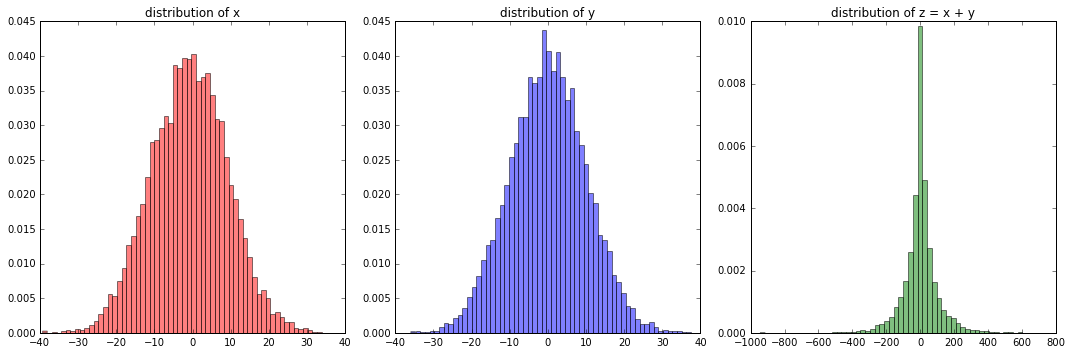

In [4]:
x = np.random.normal(-1, 10, size=10000)
y = np.random.normal(0, 10, size=10000)

z = x * y

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(x, color='red', bins=60, alpha=0.5, normed=1)
ax1.set_title('distribution of x')

ax2.hist(y, color='blue', bins=60, alpha=0.5, normed=1)
ax2.set_title('distribution of y')

ax3.hist(z, color='green', bins=60, alpha=0.5, normed=1)
ax3.set_title('distribution of z = x + y')

plt.tight_layout()
plt.show()

The product of the above two normally distributed RVs is certainly not normal. Thus, we see that in general the product of two normally distributed RVs is not normal. To rigorously derive a closed form for the distribution of $X*Y$ we again need more mathematics!

---